In [17]:
import os
date = '2019-08-06'
data_location = '/user/simon/data/soar/flat_analisis_2019B/'
full_path_data_location = os.path.join(data_location, date)
# "2019-08-06"
# "2019-08-10"
# "2019-08-23"
# "2019-09-04"
# "2019-09-06"
# "2019-09-22"
# "2019-09-23"
# "2019-10-05"
# "2019-10-08"
# "2019-10-20"
# "2019-11-02"
# "2019-11-19"
# "2019-11-29"
# "2019-12-03"
# "2019-12-15"
# "2019-12-18"
# "2019-12-19"
# "2020-01-02"
# "2020-01-19"
# "2020-01-31"


In [18]:
import os
from ccdproc import ImageFileCollection, CCDData
KEYWORDS = ['slit',
            'grating',
            'cam_targ',
            'grt_targ',
            'filter',
            'filter2',
            'gain',
            'roi',
            'wavmode',
            'exptime',
            'rdnoise']

def get_flat_files_as_pandas_dataframe():
    ifc = ImageFileCollection(location=full_path_data_location, keywords=KEYWORDS, glob_include='*FLAT*')
    df = ifc.summary.to_pandas()
    groups = df.groupby(['slit',
                         'grating',
                         'cam_targ',
                         'grt_targ',
                         'filter',
                         'filter2',
                         'gain',
                         'roi',
                         'wavmode',
                         'exptime',
                         'rdnoise']).size().reset_index().rename(
        columns={0: 'count'})
    all_groups = []
    for i in groups.index:
        conf_group = df[((df['slit'] == groups.iloc[i]['slit']) &
                         (df['grating'] == groups.iloc[i]['grating']) &
                         (df['cam_targ'] == groups.iloc[i]['cam_targ']) &
                         (df['grt_targ'] == groups.iloc[i]['grt_targ']) &
                         (df['filter'] == groups.iloc[i]['filter']) &
                         (df['filter2'] == groups.iloc[i]['filter2']) &
                         (df['gain'] == groups.iloc[i]['gain']) &
                         (df['roi'] == groups.iloc[i]['roi']) &
                         (df['wavmode'] == groups.iloc[i]['wavmode']) &
                         (df['exptime'] == groups.iloc[i]['exptime']) &
                         (df['rdnoise'] == groups.iloc[i]['rdnoise']))]
        if len(conf_group) > 2:
            all_groups.append(conf_group.sort_values(by='file'))
        else:
            print("Group's length: {}".format(len(conf_group)))
            for __File in conf_group.file.values.tolist():
                print("Discarding File: {}".format(__File))
    return all_groups

In [19]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def visualize_as_grid(group, date):
    group_name = "Date: {} Wavemode: {} Exptime: {}s".format(date, group.wavmode.unique()[0], group.exptime.unique()[0])
    nrows = int(np.ceil(len(group)/2.))
    ncols = 2
#     fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize = (16, nrows * 3 ))
   
    fig = plt.figure(figsize = (16, nrows * 3 ))
    fig.suptitle(group_name, fontsize=16)
    gs = fig.add_gridspec(ncols=ncols, nrows=nrows)
    for i, fits_file in enumerate(group.file.tolist()):
        ccd = CCDData.read(os.path.join(full_path_data_location, fits_file), unit='adu')
        z1 = np.mean(ccd.data) - 0.5 * np.std(ccd.data)
        z2 = np.median(ccd.data) + np.std(ccd.data)
        if i%2 == 0:
            y=0
        else:
            y=1
        ax_x = fig.add_subplot(gs[int(np.floor(i/2.)), y])
        ax_x.imshow(ccd.data, clim=(z1, z2), cmap='viridis')
        ax_x.title.set_text(fits_file)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])

##  August 6th


In [20]:

groups = get_flat_files_as_pandas_dataframe()

Group's length: 1
Discarding File: 0072_DFLAT-06-08-2019.fits
Group's length: 1
Discarding File: 0080_DFLAT-06-08-2019.fits
Group's length: 1
Discarding File: 0081_DFLAT-06-08-2019.fits
Group's length: 2
Discarding File: 0078_DFLAT-06-08-2019.fits
Discarding File: 0079_DFLAT-06-08-2019.fits
Group's length: 2
Discarding File: 0075_DFLAT-06-08-2019.fits
Discarding File: 0076_DFLAT-06-08-2019.fits
Group's length: 1
Discarding File: 0074_DFLAT-06-08-2019.fits


### Visual Inspection

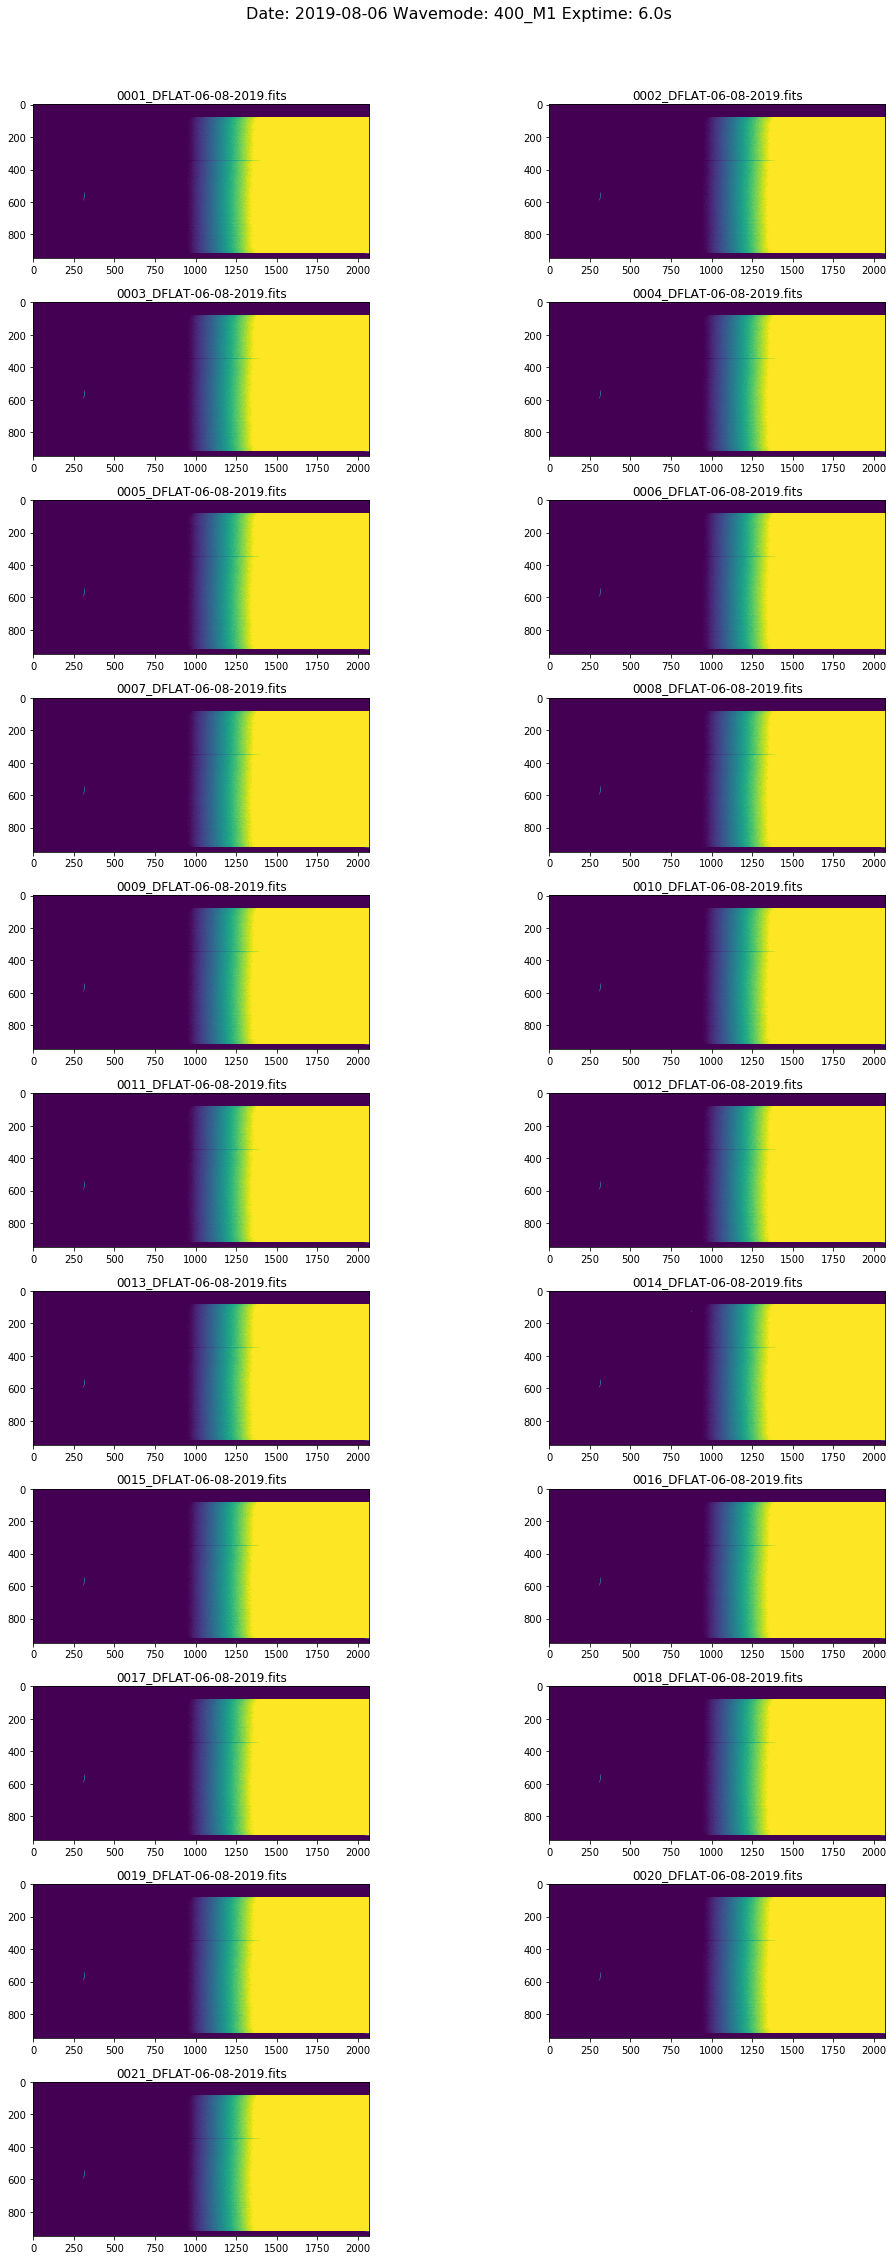

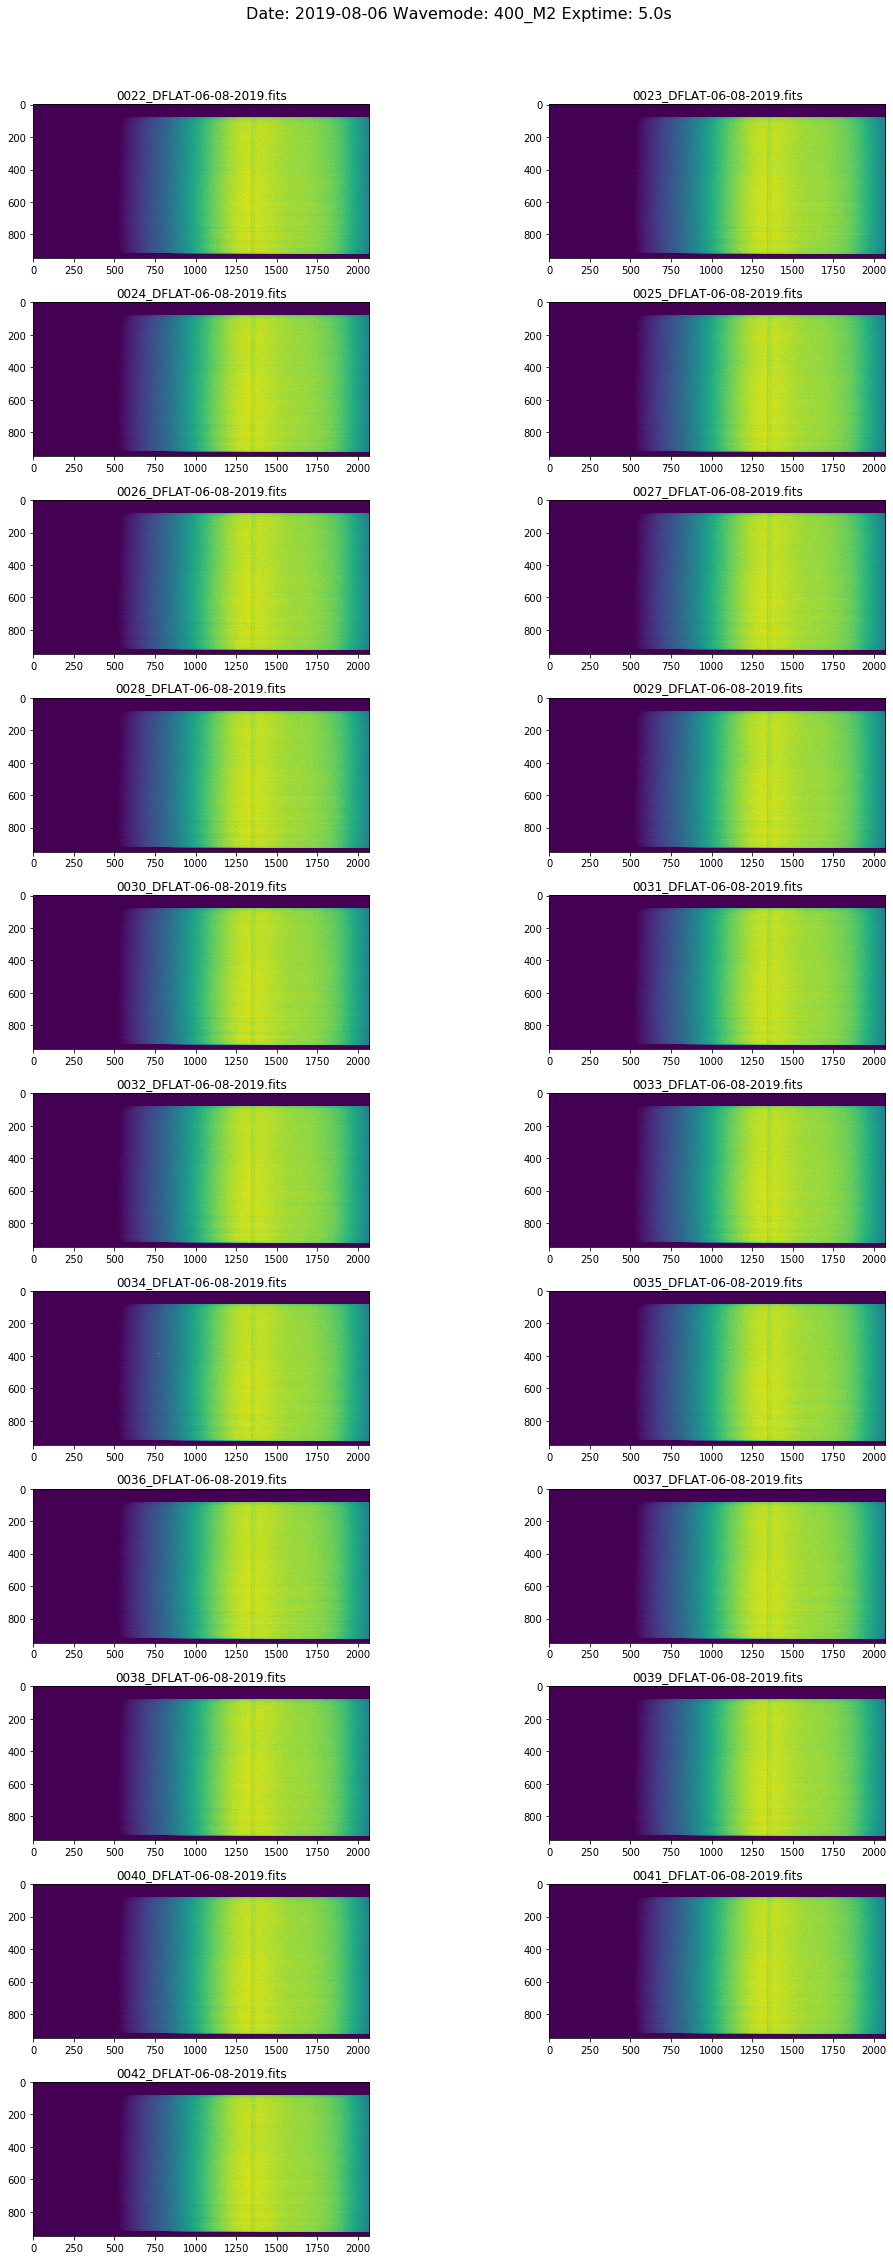

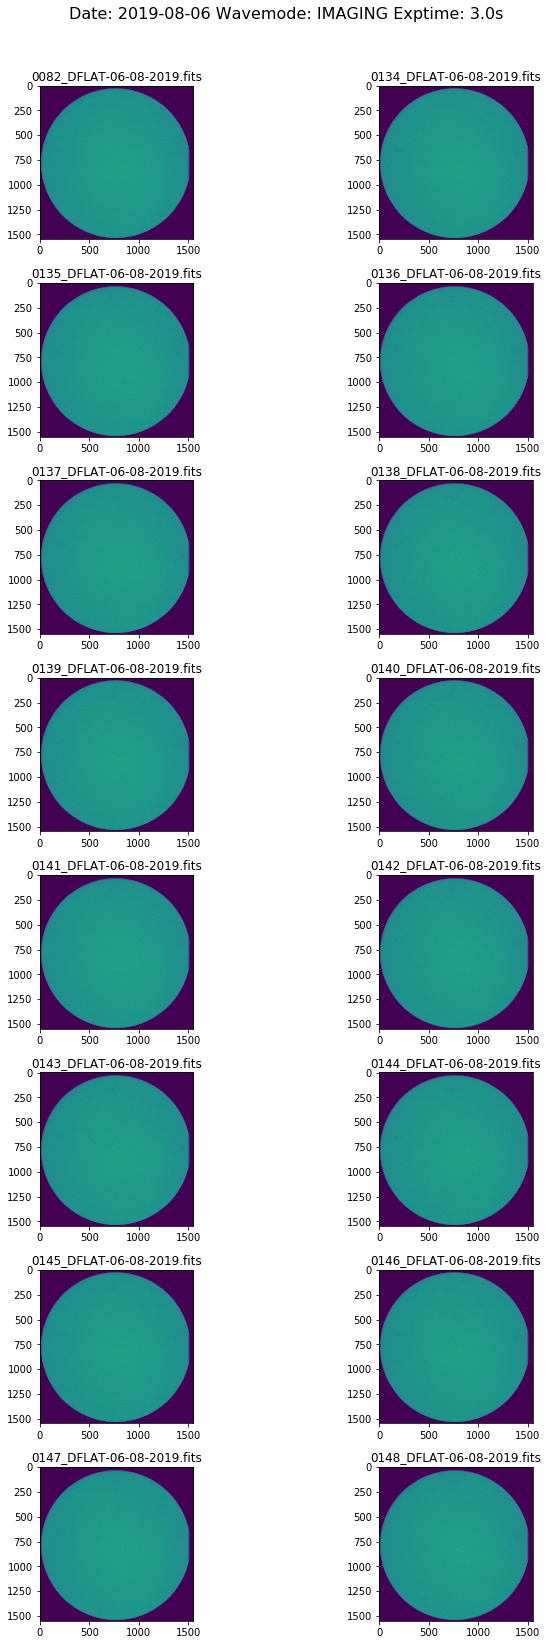

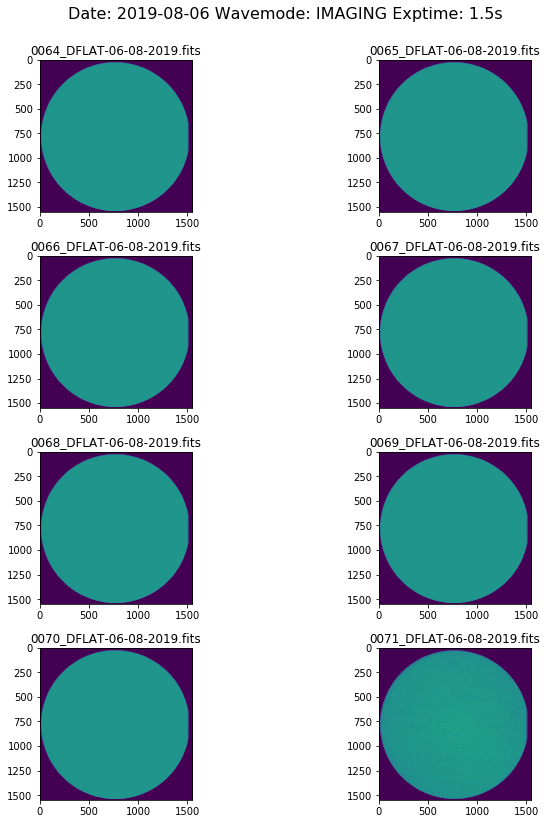

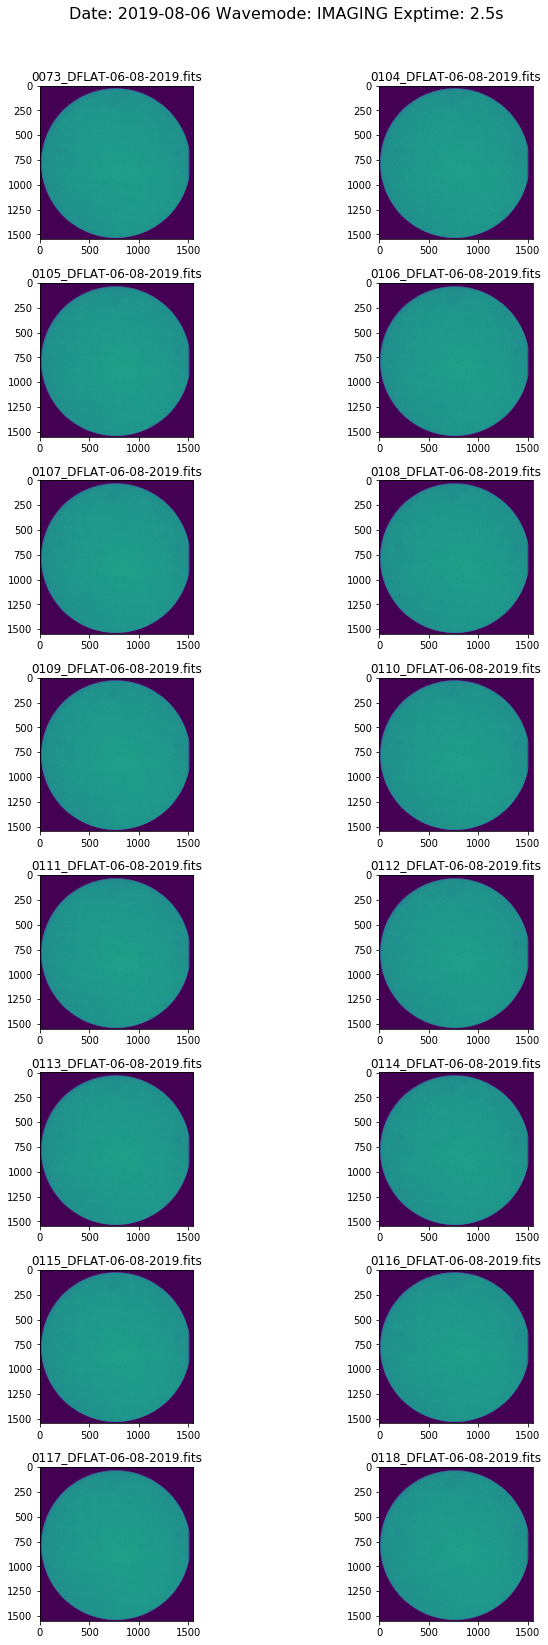

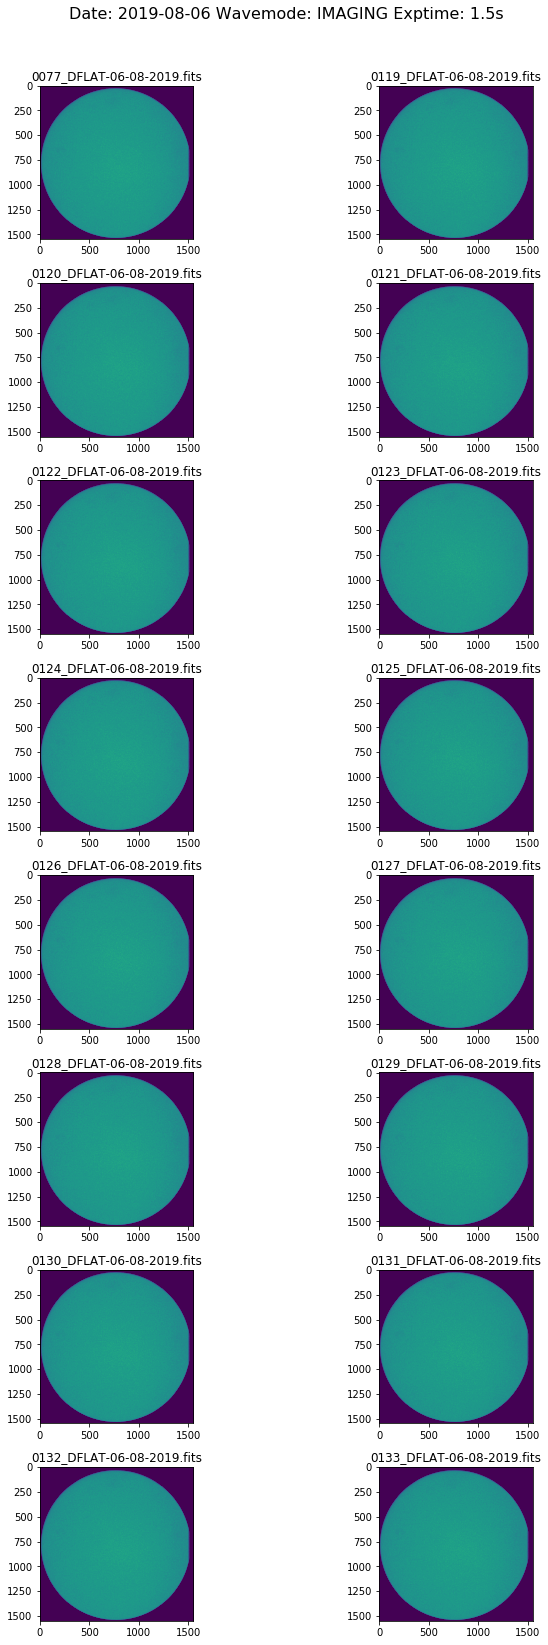

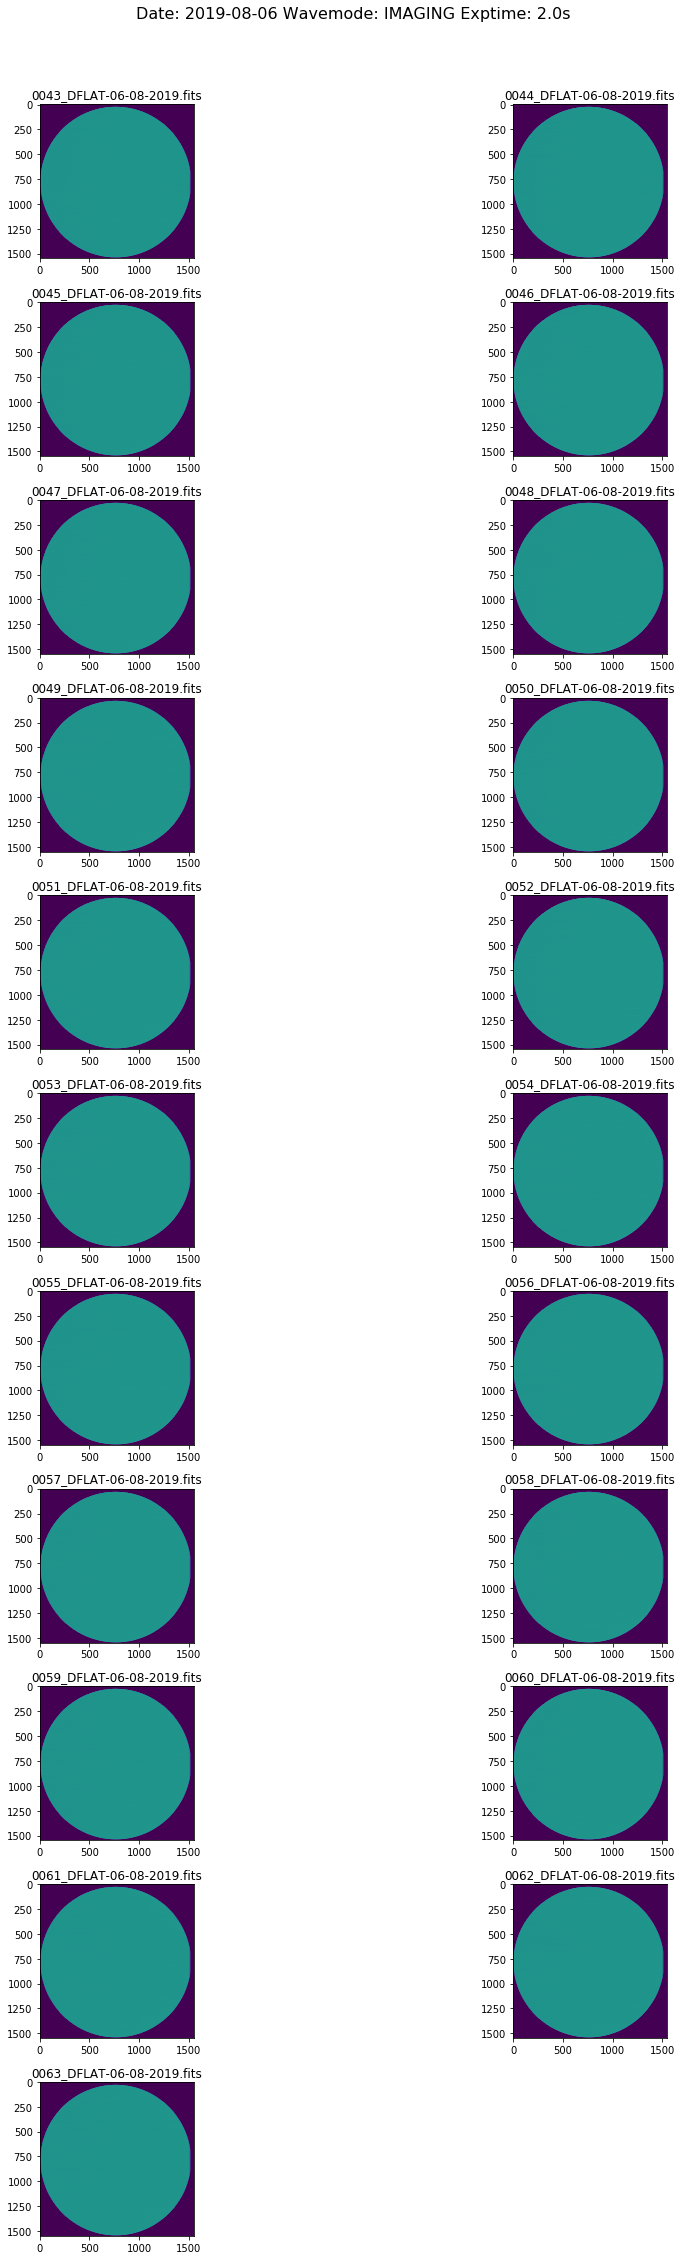

In [21]:
for group in groups:
    visualize_as_grid(group=group, date=date)

### Combine as MasterFlats

In [22]:
import re
def identify_technique(ccd):
    if 'Spectroscopic' in ccd.header['ROI'] or \
            ccd.header['OBSTYPE'] in ['ARC', 'SPECTRUM', 'COMP'] or \
            ccd.header['SLIT'] not in ['NO_MASK', '<NO MASK>'] or \
            ccd.header['GRATING'] not in ['NO_GRATING', '<NO GRATING>'] or \
            '_SP_' in ccd.header['OBJECT']:
        technique = 'Spectroscopy'
    elif 'Imaging' in ccd.header['ROI'] or \
            ccd.header['OBSTYPE'] in ['EXPOSE'] or\
            ccd.header['WAVMODE'] == 'IMAGING' or '_IM_' in ccd.header['OBJECT']:
        technique = 'Imaging'
    else:
        technique = 'Unknown'
    return technique


In [23]:
# !pip install goodman_pipeline==1.3.0rc3

In [24]:
import goodman_pipeline

print(goodman_pipeline.__version__)

from goodman_pipeline.core import create_master_flats, get_overscan_region, define_trim_section, get_slit_trim_section

1.3.0rc3


In [27]:
def combine_flats(group):
    new_data = []
    file_list = group.file.tolist()
    sample_file = os.path.join(data_location, date, file_list[0])
    sample_ccd = CCDData.read(sample_file, unit='adu')
    technique = identify_technique(ccd=sample_ccd)
    
    overscan_region = get_overscan_region(sample_image=sample_file, technique=technique)
    trim_section = define_trim_section(sample_image=sample_file, technique=technique)
    if technique == 'Spectroscopy':
        new_master_flat_name = "master_flat_{}_{}.fits".format(
            re.sub(' ', '_', sample_ccd.header['WAVMODE']),
            re.sub('[<> ]', '', sample_ccd.header['FILTER2']))
    else:
        new_master_flat_name = "master_flat_{}_{}.fits".format(
            re.sub(' ', '_', sample_ccd.header['WAVMODE']),
            re.sub('[<> ]', '', sample_ccd.header['FILTER']))
    
    master_flat, master_flat_name = create_master_flats(
        flat_files=file_list, 
        raw_data=os.path.join(data_location, date), 
        reduced_data=os.path.join(full_path_data_location, 'masters'), 
        technique=technique, 
        overscan_region=overscan_region, 
        trim_section=trim_section, 
        master_bias_name='', 
        new_master_flat_name=new_master_flat_name, 
        saturation_threshold=1, 
        ignore_bias=True,)
    if technique == 'Spectroscopy':
        trim_section = get_slit_trim_section(master_flat=master_flat)
        
        master_flat = goodman_pipeline.core.image_trim(ccd=master_flat, trim_section=trim_section, trim_type='slit')
        master_flat.write(master_flat_name, overwrite=True)
        divider = 2.
    else:
        divider = 1.
    
    fig, ax = plt.subplots(figsize=(16, int(16/divider)))
    ax.title.set_text(os.path.basename(master_flat_name))
    z1 = np.mean(master_flat.data) - 0.5 * np.std(master_flat.data)
    z2 = np.median(master_flat.data) + np.std(master_flat.data)
    ax.imshow(master_flat.data, clim=(z1, z2), cmap='viridis')
    plt.show()
    print(master_flat_name)
    return technique, master_flat

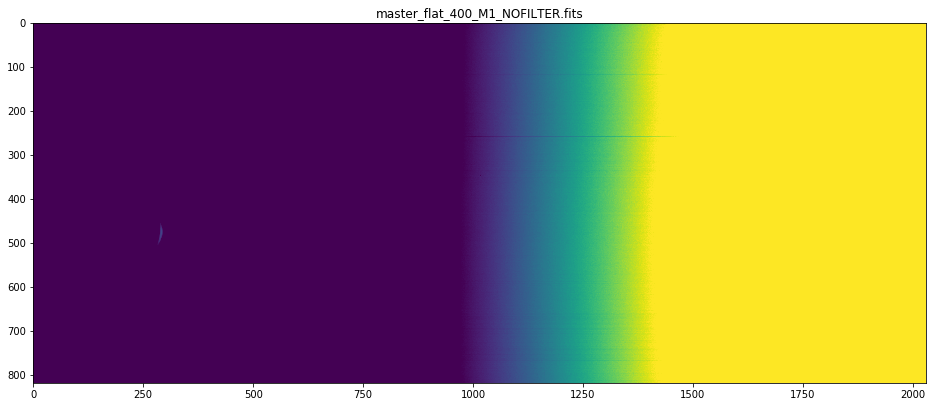

/user/simon/data/soar/flat_analisis_2019B/2019-08-06/masters/master_flat_400_M1_NOFILTER.fits


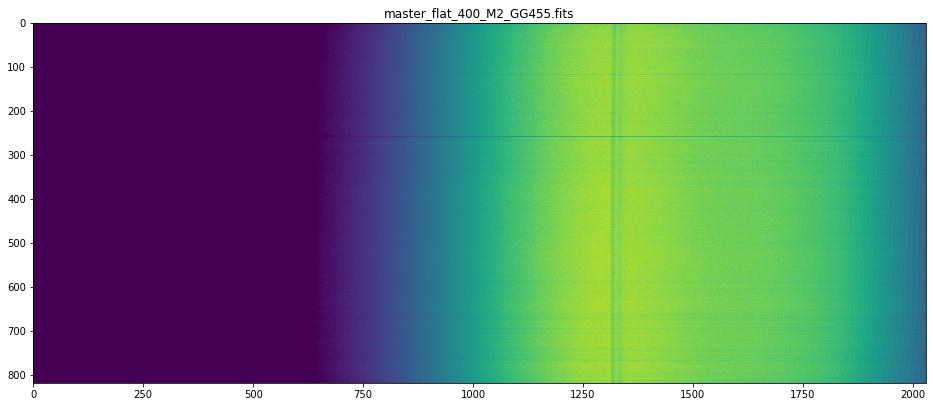

/user/simon/data/soar/flat_analisis_2019B/2019-08-06/masters/master_flat_400_M2_GG455.fits


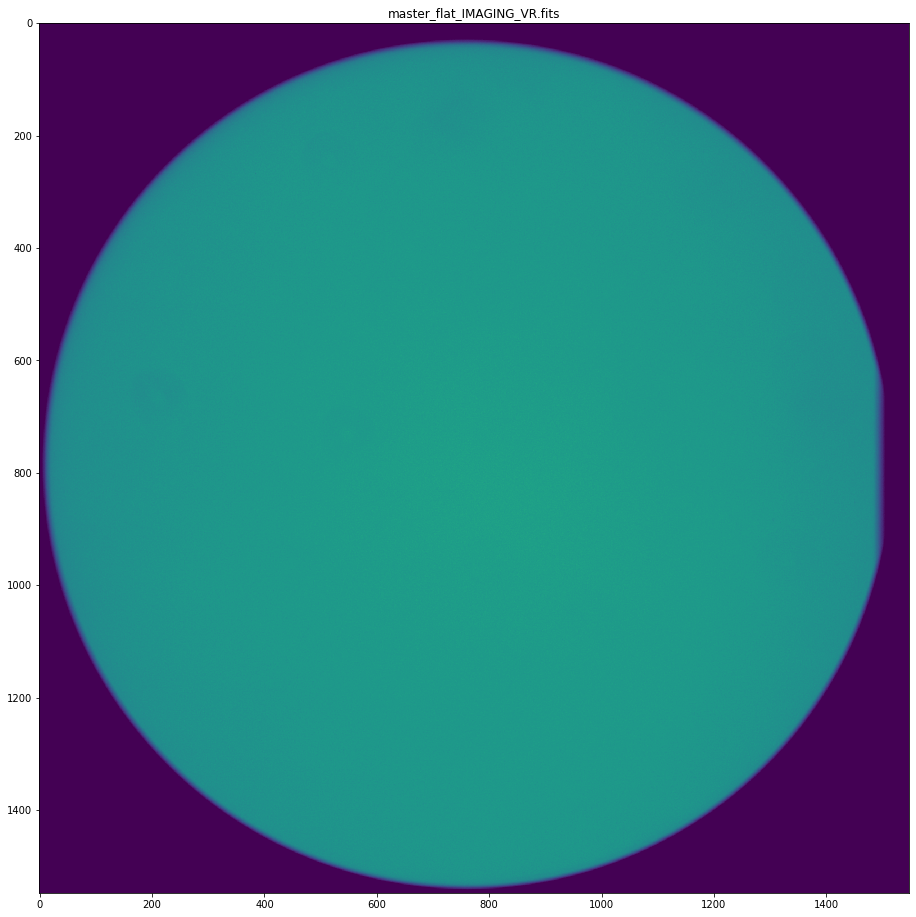

/user/simon/data/soar/flat_analisis_2019B/2019-08-06/masters/master_flat_IMAGING_VR.fits


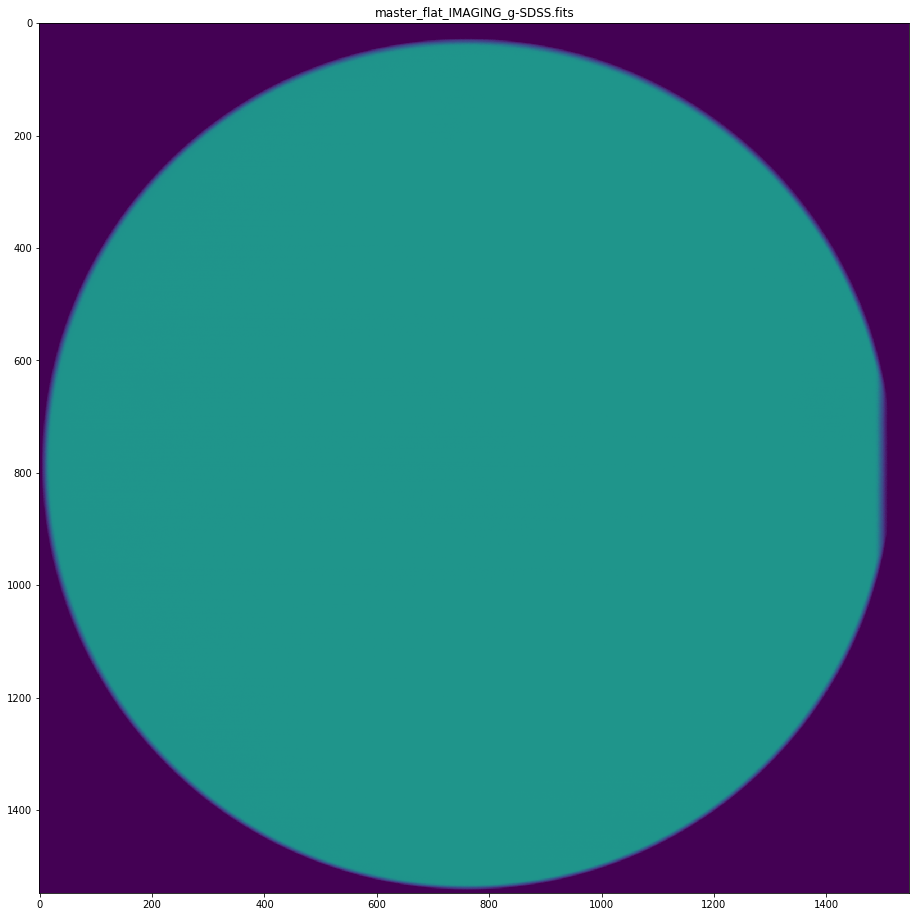

/user/simon/data/soar/flat_analisis_2019B/2019-08-06/masters/master_flat_IMAGING_g-SDSS.fits


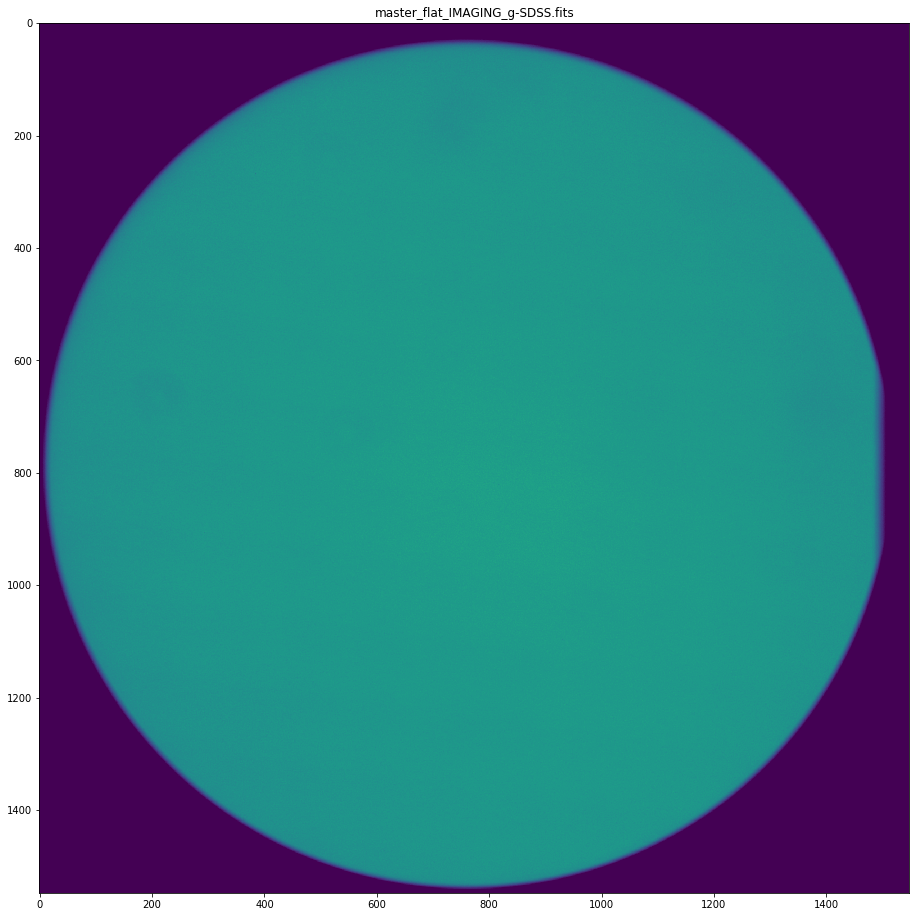

/user/simon/data/soar/flat_analisis_2019B/2019-08-06/masters/master_flat_IMAGING_g-SDSS.fits


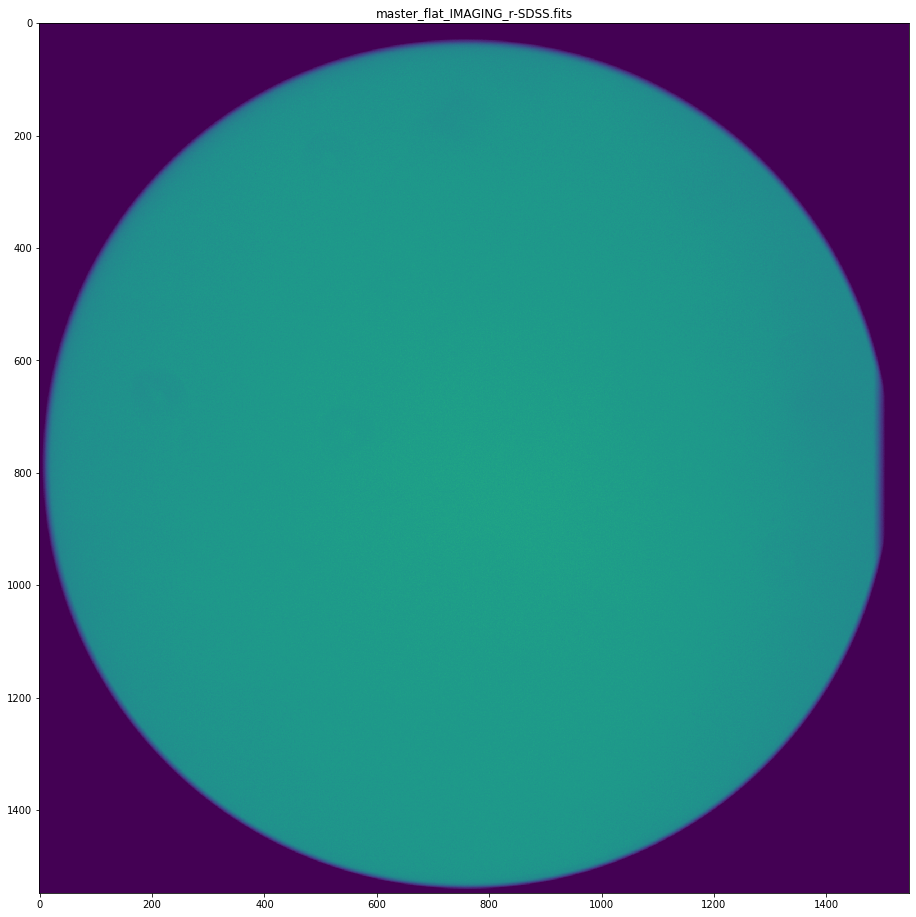

/user/simon/data/soar/flat_analisis_2019B/2019-08-06/masters/master_flat_IMAGING_r-SDSS.fits


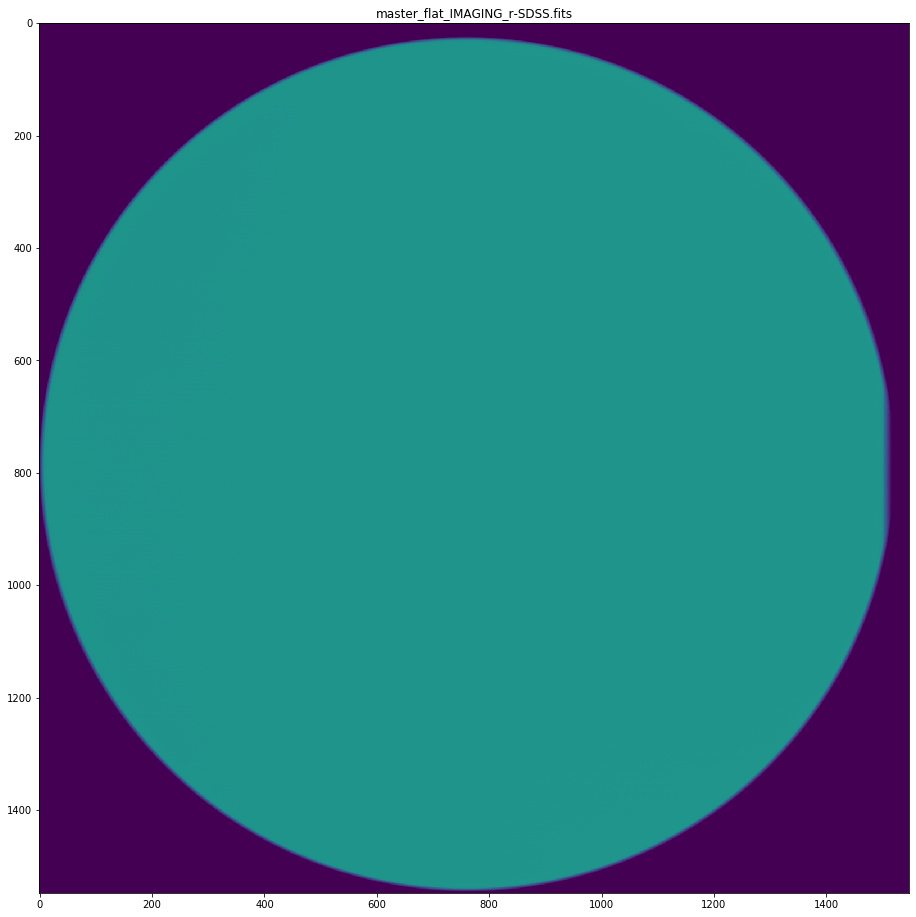

/user/simon/data/soar/flat_analisis_2019B/2019-08-06/masters/master_flat_IMAGING_r-SDSS.fits


In [28]:
all_data = []
for group in groups:
    technique, master_flat = combine_flats(group=group)
    all_data.append([group, technique, master_flat])

### Statistics


In [29]:
import logging

logger = logging.getLogger(__name__)
logger.propagate = False

In [42]:
%matplotlib inline

Spectroscopy Group Filter2: <NO FILTER> Grating: 400_SYZY Slit: 1.0_LONG_SLIT Wavmode: 400_M1
(948, 2071)
[:, 424:524]
(101, 2071)
(2071,)
(948, 2071)
[:, 424:524]
(101, 2071)
(2071,)
(948, 2071)
[:, 424:524]
(101, 2071)
(2071,)
(948, 2071)
[:, 424:524]
(101, 2071)
(2071,)
(948, 2071)
[:, 424:524]
(101, 2071)
(2071,)
(948, 2071)
[:, 424:524]
(101, 2071)
(2071,)


(948, 2071)
[:, 424:524]
(101, 2071)
(2071,)
(948, 2071)
[:, 424:524]
(101, 2071)
(2071,)
(948, 2071)
[:, 424:524]
(101, 2071)
(2071,)
(948, 2071)
[:, 424:524]
(101, 2071)
(2071,)
(948, 2071)
[:, 424:524]
(101, 2071)
(2071,)
(948, 2071)
[:, 424:524]
(101, 2071)
(2071,)
(948, 2071)
[:, 424:524]
(101, 2071)
(2071,)
(948, 2071)
[:, 424:524]


(101, 2071)
(2071,)
(948, 2071)
[:, 424:524]
(101, 2071)
(2071,)
(948, 2071)
[:, 424:524]
(101, 2071)
(2071,)
(948, 2071)
[:, 424:524]
(101, 2071)
(2071,)
(948, 2071)
[:, 424:524]
(101, 2071)
(2071,)
(948, 2071)
[:, 424:524]
(101, 2071)
(2071,)
(948, 2071)
[:, 424:524]
(101, 2071)
(2071,)


(948, 2071)
[:, 424:524]
(101, 2071)
(2071,)
Spectroscopy Group Filter2: GG455 Grating: 400_SYZY Slit: 1.0_LONG_SLIT Wavmode: 400_M2
(948, 2071)
[:, 424:524]
(101, 2071)
(2071,)
(948, 2071)
[:, 424:524]
(101, 2071)
(2071,)
(948, 2071)
[:, 424:524]
(101, 2071)
(2071,)
(948, 2071)
[:, 424:524]
(101, 2071)
(2071,)
(948, 2071)
[:, 424:524]


(101, 2071)
(2071,)
(948, 2071)
[:, 424:524]
(101, 2071)
(2071,)
(948, 2071)
[:, 424:524]
(101, 2071)
(2071,)
(948, 2071)
[:, 424:524]
(101, 2071)
(2071,)
(948, 2071)
[:, 424:524]
(101, 2071)
(2071,)
(948, 2071)
[:, 424:524]
(101, 2071)
(2071,)
(948, 2071)
[:, 424:524]
(101, 2071)
(2071,)


(948, 2071)
[:, 424:524]
(101, 2071)
(2071,)
(948, 2071)
[:, 424:524]
(101, 2071)
(2071,)
(948, 2071)
[:, 424:524]
(101, 2071)
(2071,)
(948, 2071)
[:, 424:524]
(101, 2071)
(2071,)
(948, 2071)
[:, 424:524]
(101, 2071)
(2071,)
(948, 2071)
[:, 424:524]
(101, 2071)
(2071,)
(948, 2071)
[:, 424:524]
(101, 2071)
(2071,)
(948, 2071)
[:, 424:524]
(101, 2071)
(2071,)


(948, 2071)
[:, 424:524]
(101, 2071)
(2071,)
(948, 2071)
[:, 424:524]
(101, 2071)
(2071,)
Imaging Group Filter: VR


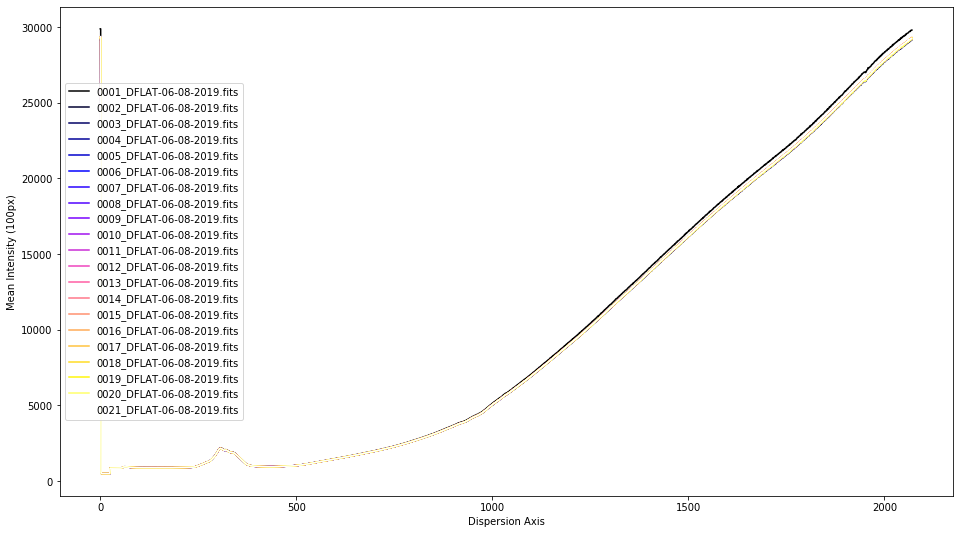

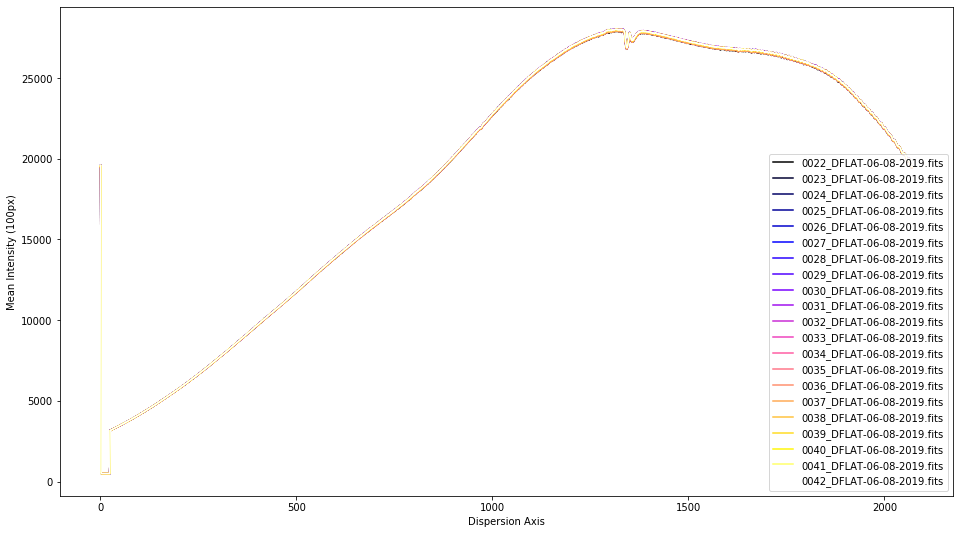

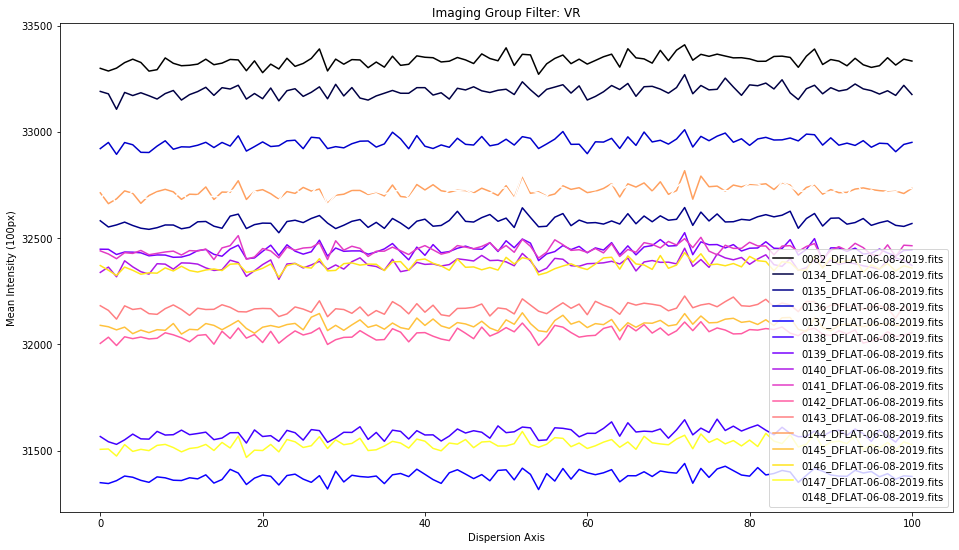

                          file   npix          mean      stddev    min    max
0   0082_DFLAT-06-08-2019.fits  10201  33334.188903  245.864084  28775  34291
1   0134_DFLAT-06-08-2019.fits  10201  33191.688364  247.030644  28660  34110
2   0135_DFLAT-06-08-2019.fits  10201  32578.295069  241.147763  27815  33541
3   0136_DFLAT-06-08-2019.fits  10201  32948.617979  246.591788  28358  33884
4   0137_DFLAT-06-08-2019.fits  10201  31382.560435  236.160444  27066  32315
5   0138_DFLAT-06-08-2019.fits  10201  31582.590432  237.235579  27327  32540
6   0139_DFLAT-06-08-2019.fits  10201  32445.766003  241.144181  27896  33450
7   0140_DFLAT-06-08-2019.fits  10201  32378.227429  242.175197  27716  33346
8   0141_DFLAT-06-08-2019.fits  10201  32447.916577  246.237505  27732  33522
9   0142_DFLAT-06-08-2019.fits  10201  32049.405058  236.873527  27566  33161
10  0143_DFLAT-06-08-2019.fits  10201  32171.348103  241.257953  27701  33104
11  0144_DFLAT-06-08-2019.fits  10201  32723.482404  245.194651 

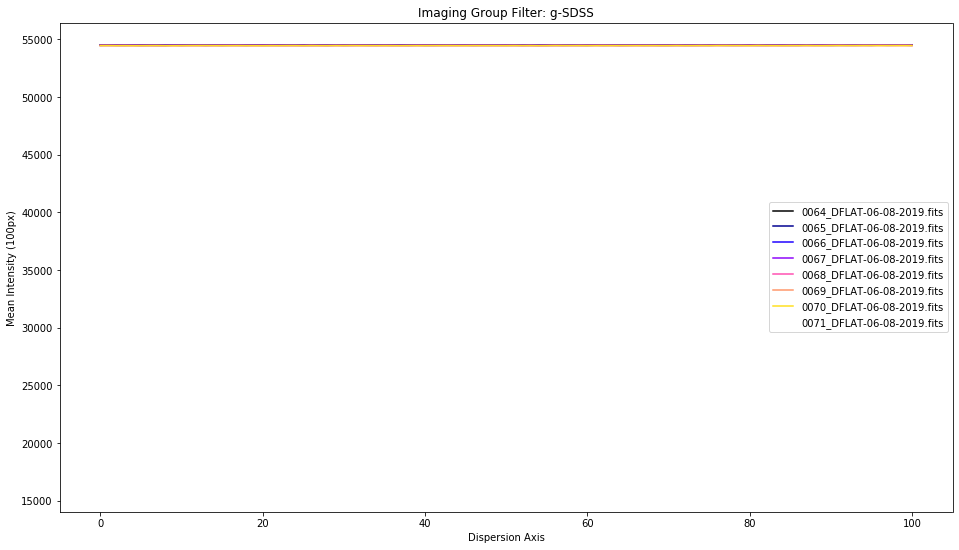

                         file   npix          mean      stddev    min    max
0  0064_DFLAT-06-08-2019.fits  10201  54518.368885   58.848669  54178  54763
1  0065_DFLAT-06-08-2019.fits  10201  54482.193020   57.933988  54135  54679
2  0066_DFLAT-06-08-2019.fits  10201  54488.520635   58.679856  54209  54670
3  0067_DFLAT-06-08-2019.fits  10201  54481.640231   57.522852  54231  54694
4  0068_DFLAT-06-08-2019.fits  10201  54465.920302   53.640390  54243  54682
5  0069_DFLAT-06-08-2019.fits  10201  54463.480541   55.456223  54213  54658
6  0070_DFLAT-06-08-2019.fits  10201  54459.755220   59.659677  54246  54647
7  0071_DFLAT-06-08-2019.fits  10201  16016.857073  159.661661  13183  16601
 
Imaging Group Filter: g-SDSS


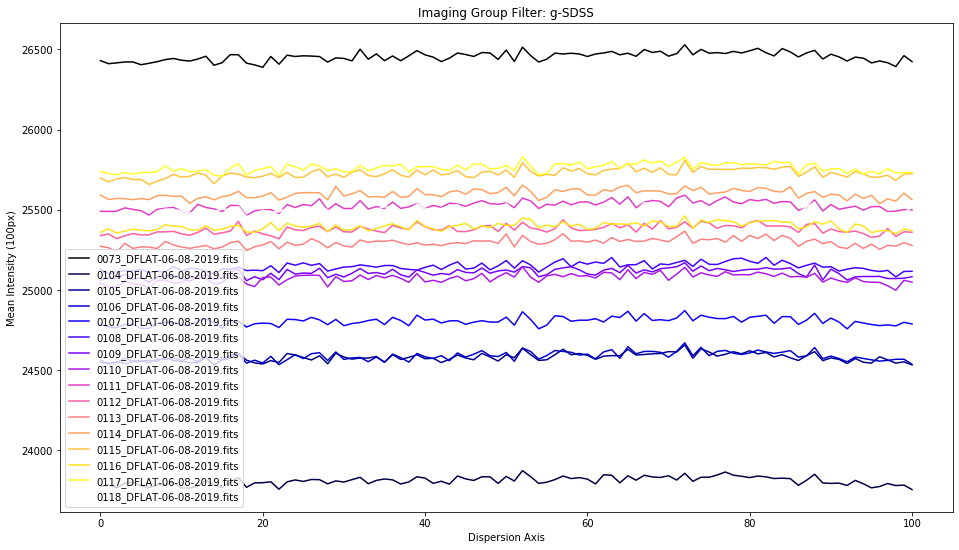

                          file   npix          mean      stddev    min    max
0   0073_DFLAT-06-08-2019.fits  10201  26454.836683  241.573634  22318  28290
1   0104_DFLAT-06-08-2019.fits  10201  23810.490540  218.238610  19819  24565
2   0105_DFLAT-06-08-2019.fits  10201  24579.780414  228.199183  20716  27269
3   0106_DFLAT-06-08-2019.fits  10201  24587.078620  223.917232  20887  25419
4   0107_DFLAT-06-08-2019.fits  10201  24806.019312  227.659760  20911  25752
5   0108_DFLAT-06-08-2019.fits  10201  25146.538673  229.588592  21167  26036
6   0109_DFLAT-06-08-2019.fits  10201  25105.572983  229.329988  21120  26018
7   0110_DFLAT-06-08-2019.fits  10201  25073.815508  227.787735  21080  25977
8   0111_DFLAT-06-08-2019.fits  10201  25526.377904  233.185369  21525  26400
9   0112_DFLAT-06-08-2019.fits  10201  25378.697677  231.382084  21430  26313
10  0113_DFLAT-06-08-2019.fits  10201  25294.886874  231.597399  21217  26283
11  0114_DFLAT-06-08-2019.fits  10201  25598.928242  234.295515 

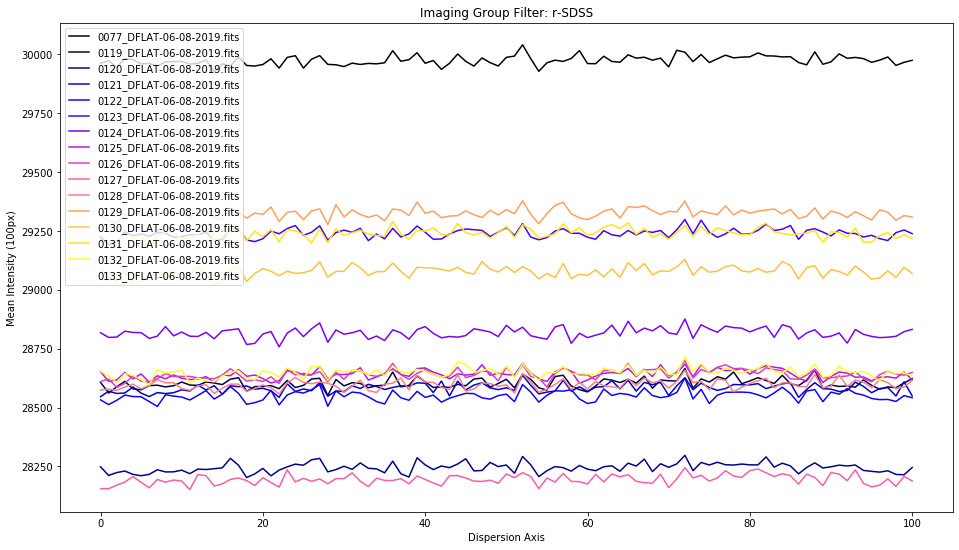

                          file   npix          mean      stddev    min    max
0   0077_DFLAT-06-08-2019.fits  10201  29973.796196  231.765607  25616  30890
1   0119_DFLAT-06-08-2019.fits  10201  28603.140182  221.615130  24455  29444
2   0120_DFLAT-06-08-2019.fits  10201  28244.620527  222.123800  23903  29145
3   0121_DFLAT-06-08-2019.fits  10201  28582.364964  220.959157  24308  29369
4   0122_DFLAT-06-08-2019.fits  10201  28550.394373  223.612465  24410  29461
5   0123_DFLAT-06-08-2019.fits  10201  29239.763160  229.043561  24941  30187
6   0124_DFLAT-06-08-2019.fits  10201  28816.566023  224.696696  24649  29674
7   0125_DFLAT-06-08-2019.fits  10201  28641.174591  224.612056  24382  29429
8   0126_DFLAT-06-08-2019.fits  10201  28640.377806  223.845231  24528  29442
9   0127_DFLAT-06-08-2019.fits  10201  28194.469170  220.462929  23947  29046
10  0128_DFLAT-06-08-2019.fits  10201  28597.017057  225.720947  24235  29426
11  0129_DFLAT-06-08-2019.fits  10201  29324.801392  229.632230 

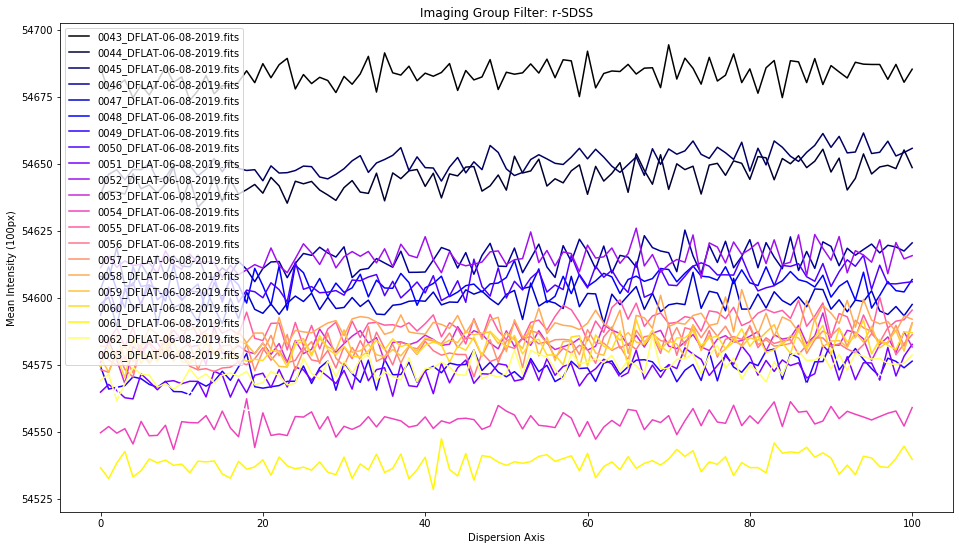

                          file   npix          mean     stddev    min    max
0   0043_DFLAT-06-08-2019.fits  10201  54683.193805  53.196576  54468  54859
1   0044_DFLAT-06-08-2019.fits  10201  54644.777375  53.957091  54453  54844
2   0045_DFLAT-06-08-2019.fits  10201  54650.854034  49.974347  54459  54835
3   0046_DFLAT-06-08-2019.fits  10201  54614.170572  52.891683  54429  54817
4   0047_DFLAT-06-08-2019.fits  10201  54598.328791  54.452977  54415  54800
5   0048_DFLAT-06-08-2019.fits  10201  54605.081169  56.024317  54350  54776
6   0049_DFLAT-06-08-2019.fits  10201  54572.650524  51.687953  54382  54743
7   0050_DFLAT-06-08-2019.fits  10201  54605.404470  53.016380  54407  54794
8   0051_DFLAT-06-08-2019.fits  10201  54572.031468  58.650952  54348  54788
9   0052_DFLAT-06-08-2019.fits  10201  54614.966964  55.255601  54404  54844
10  0053_DFLAT-06-08-2019.fits  10201  54583.191942  56.818579  54376  54807
11  0054_DFLAT-06-08-2019.fits  10201  54553.653367  56.535805  54356  54741

In [43]:
import pandas as pd
for group, technique, master_flat in all_data:
    cmap = plt.get_cmap('gnuplot2')
    colors = [cmap(i) for i in np.linspace(0, 1, len(group))]
    if technique == 'Spectroscopy':
        print('Spectroscopy Group Filter2: {} Grating: {} Slit: {} Wavmode: {}'.format(group.filter2.unique()[0],
                                                                                       group.grating.unique()[0], 
                                                                                       group.slit.unique()[0], 
                                                                                       group.wavmode.unique()[0]))
              
        fig_1, ax_1 = plt.subplots(figsize=(16,9))
#         fig_1, ax_1 = plt.subplots()
        ax_1.set_xlabel('Dispersion Axis')
        ax_1.set_ylabel('Mean Intensity (100px)')
        
        cmap = plt.get_cmap('gnuplot2')
        colors = [cmap(i) for i in np.linspace(0, 1, len(group))]
        
        for i, _image in enumerate(group.file.tolist()):
            ccd = CCDData.read(os.path.join(full_path_data_location, _image), unit='adu')
            x, y = ccd.data.shape
            print(ccd.data.shape)
            x_0 = int(x / 2.) - 50
            x_1 = int(x / 2.) + 50
            
            y_0 = 1
            y_1 = y
            
            region = "[:, {}:{}]".format(x_0, x_1)
            print(region)
            ccd = goodman_pipeline.core.image_trim(ccd=ccd, trim_section=region, trim_type='subsection')
            print(ccd.data.shape)
            ccd.data = np.mean(ccd.data, axis=0)
            print(ccd.data.shape)
            ax_1.plot(ccd.data, color=colors[i], label=_image)
        plt.legend(loc='best')
#         plt.show()
    else:
        _title = 'Imaging Group Filter: {}'.format(group['filter'].unique()[0])
        print(_title)
        _data = {'file': [], 'npix': [], 'mean': [], 'stddev': [], 'min': [], 'max': []}
        
        fig, ax = plt.subplots(figsize=(16,9))
#         fig, ax = plt.subplots()
        ax.set_xlabel('Dispersion Axis')
        ax.set_ylabel('Mean Intensity (100px)')
        ax.set_title(_title)
        
        for i, _image in enumerate(group.file.tolist()):
            ccd = CCDData.read(os.path.join(full_path_data_location, _image), unit='adu')
            x, y = ccd.data.shape
            x_0 = int(x / 2.) - 50
            x_1 = int(x / 2.) + 50
            
            y_0 = int(y / 2.) - 50
            y_1 = int(y / 2.) + 50
            
            region = "[{}:{}, {}:{}]".format(x_0, x_1, y_0, y_1)
            ccd = goodman_pipeline.core.image_trim(ccd=ccd, trim_section=region, trim_type='subsection')
#             fig, ax = plt.subplots(figsize=(16, 9))
#             ax.imshow(ccd.data, cmap='viridis')
            # IMAGE      NPIX      MEAN    STDDEV       MIN       MAX
            _npix = np.prod(ccd.data.shape)
            _mean = np.mean(ccd.data)
            _stdev = np.std(ccd.data)
            _min = np.min(ccd.data)
            _max = np.max(ccd.data)
            _data['file'].append(_image)
            _data['npix'].append(_npix)
            _data['mean'].append(_mean)
            _data['stddev'].append(_stdev)
            _data['min'].append(_min)
            _data['max'].append(_max)
            
            
            mean_data = np.mean(ccd.data, axis=0)
            ax.plot(mean_data, color=colors[i], label=_image)
        plt.legend(loc='best')
        plt.show()
            
        df = pd.DataFrame(data=_data)
        print(df.to_string())
        print(" ")
            
            

#             print("extraction zone [{}:{}, {}:{}]".format(x_0, x_1, y_0, y_1))
             

In [35]:
!pwd

/data/simon/documentation/soar/general_documentation/jupyter-notebooks/SOAR_Analisys/2019B_Flats
